In [2]:
## Packages
# system
import os
import math
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, recall_score, make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.preprocessing import normalize, StandardScaler

## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

In [4]:
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

## Data Import

In [148]:
df = pd.read_csv('../processed_data/provider_final_new.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('Provider')
display(df.shape)
df.head(3)

(5410, 46)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4.0,5.00000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0,1.0,4185.600000,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes,1.44,24,25,1.04,109980,4582.50,0,2,23,1.09
PRV51003,Yes,4.0,5.16129,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0,1.0,4588.409091,25.0,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
PRV51004,No,0.0,0.00000,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,0.0,138.0,0.0,9.0,1.0,350.134228,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes,1.43,138,149,1.08,52480,380.29,0,12,149,1.27


## dummy variables

In [149]:
# Make dummies
encode_cols = df[~df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
print(encode_cols)
df[encode_cols[2:]] = df[encode_cols[2:]].applymap(lambda x: 1 if x.lower() == 'yes' else 0)
dummies = pd.get_dummies(df['Serves'],prefix='Serves_',drop_first=True)
df_dum = pd.concat([df.drop('Serves',axis=1),dummies],axis=1)
df_dum.shape

['PotentialFraud', 'Serves', 'DupClaim_IP', 'DupClaimMultiState_IP', 'DupClaimMultiProvider_IP', 'DupClaimMultiStartDt_IP', 'DupClaim_OP', 'DupClaimMultiState_OP', 'DupClaimMultiProvider_OP', 'DupClaimMultiStartDt_OP']


(5410, 47)

#### convert potential fraud flag to 1 & 0

In [150]:
# this is for pos_label for precision & recall for gridsearchcv
df_dum['PotentialFraud'] = np.where(df_dum['PotentialFraud']=='Yes', 1, 0)

In [151]:
display(df_dum.shape)
display(df_dum.sample(3))

(5410, 47)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt,Serves__IP,Serves__OP
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51846,0,4.5,4.500000,0.0,1.000000,7.0,6.655172,8.0,67.0,65.482759,1.0,24.0,1.0,1.0,1.0,657.586207,1.0,0.0,0.000000,0,0.0,0,0.0,0,0.0,0,11.0,0.407407,1,52.0,1,2327.0,1,371.0,1,1.24,25,29,1.16,21306,852.24,0,2,27,1.04,0,0
PRV55138,0,15.0,13.333333,0.0,0.000000,2.0,3.666667,2.0,82.0,83.666667,3.0,0.0,1.0,0.0,1.0,8333.333333,3.0,0.0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0,0.0,0,13.33,3,3,1.00,28204,9401.33,0,0,1,1.00,1,0
PRV53381,0,5.0,5.909091,0.0,1.545455,7.0,6.606061,7.0,75.0,74.939394,9.0,22.0,1.0,1.0,1.0,4185.454545,6.0,1.0,0.090909,1,2.0,1,2.0,1,2.0,1,12.0,0.545455,1,51.0,1,1274.0,1,365.0,1,3.00,29,33,1.14,149938,5170.28,0,1,29,1.03,0,0


## Logistic Regression

### train-test-split for logistic regression

In [72]:
# remove Duration MedianIP
df_dum_drop = df_dum.drop(['DurationMedianIP'], axis=1)

In [73]:
x = df_dum_drop.drop(['PotentialFraud'], axis = 1)
y = df_dum_drop.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [74]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 45)
(4328, 45)
(1082, 45)


### normalization / standardization

In [75]:
ss = StandardScaler()
ss.fit(xtrain)
xstrain = ss.transform(xtrain)

### grid search for LR

In [133]:
''' 1: recall of positive - sensitivity; recall of negative - specificity
2: score function arugment average: use binary instead of weighted (usually for multiclass), 
because already have class_weight = balanced in lr, for evaluation don't want to weighted based on proportion'''

lr = LogisticRegression(class_weight='balanced') 

lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 

# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 

# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear']}, 
#              {'penalty': ['elasticnet'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear'], 'l1_ratio':[0.2, 0.4, 0.6, 0.8]}] # l1=lasso


scores = {'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), 
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')}

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = 10, verbose=2, scoring=scores, refit=False, n_jobs=-1) 
# used cv = 5 before, for small data set use higher fold of cross validation

%time lr_grid.fit(xtrain, ytrain)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


CPU times: user 694 ms, sys: 303 ms, total: 997 ms
Wall time: 12.6 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01,...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make_scorer(r

In [134]:
keys = list(lr_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [135]:
lr_grid_scores = pd.DataFrame({'params': lr_grid.cv_results_['params'], 
              'mean_validation_recall': lr_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': lr_grid.cv_results_['mean_train_recall'],
              'mean_validation_f1': lr_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': lr_grid.cv_results_['mean_train_f1'],
              'mean_validation_precision': lr_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': lr_grid.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': lr_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': lr_grid.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': lr_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': lr_grid.cv_results_['mean_train_specificity'],
              'mean_validation_roc_auc_score': lr_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': lr_grid.cv_results_['mean_train_roc_auc_score']
             })

# lr_grid_scores.to_csv('../output/lr_grid_scores_l1l2_dropDurationMedianIP.csv')
lr_grid_scores.to_csv('../output/lr_grid_scores_l1_dropDurationMedianIP_cv10.csv')
# lr_grid_scores.to_csv('../output/lr_grid_scores_l1l2_dropDurationMedianIP_cv10.csv')
# lr_grid_scores

In [136]:
# never split data into T/F and handle them differently
# L2 is more flexible because it is smooth function, L1 is not a smooth function
# elasticnet may keep need to use the solver that works for L1, because L2 is more flexbile
# preceision expected to be 90-95%
# can change the threshold of probabilty
# np.logspace(-4, 4, 20)

### plots of scores

In [137]:
lr_grid_scores_validation = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('validation')]]
display(lr_grid_scores_validation.shape)
display(lr_grid_scores_validation.head(2))
lr_grid_scores_train = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('train')]]
display(lr_grid_scores_train.shape)
display(lr_grid_scores_train.head(2))

(7, 6)

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.807744,0.570369,0.441656,0.851231,0.894718,0.851231
1,0.812683,0.571120,0.440811,0.853194,0.893705,0.853194


(7, 6)

,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.814819,0.575773,0.445213,0.854970,0.895120,0.854970
1,0.813449,0.576637,0.446678,0.854681,0.895913,0.854681


Text(0.5, 1.0, 'Logistic Regression Grid Search Model Scores: Validation & Train')

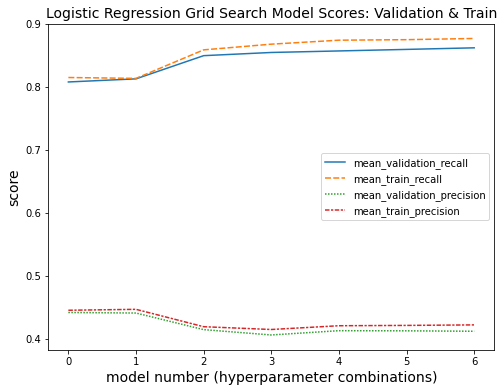

In [138]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores[['mean_validation_recall','mean_train_recall',
                                   'mean_validation_precision','mean_train_precision']])
plt.legend(loc=5)#bbox_to_anchor=(1.05,1),
# plt.xlim(0,10)
# plt.xticks(np.arange(0,10,1))
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Validation & Train', fontsize = 14)
# plt.savefig('../output/lr_gridsearch_scores_l1l2_validation_train_4score_dropDurationMedianIP.png', bbox_inches='tight')

Text(0.5, 1.0, 'Logistic Regression Grid Search Model Scores: Validation')

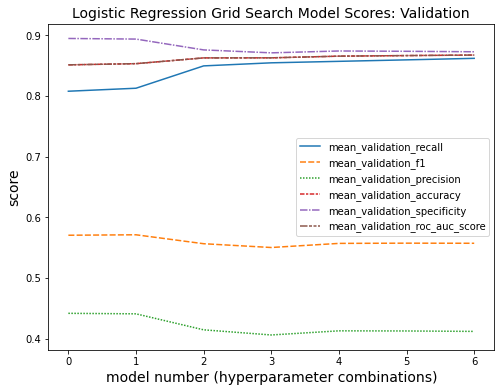

In [139]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_validation)
plt.legend(loc=5)#bbox_to_anchor=(1.05,1),
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Validation', fontsize = 14)
# plt.savefig('../output/lr_gridsearch_scores_l1_validation_dropDurationMedianIP_cv10.png', bbox_inches='tight')
# plt.savefig('../output/lr_gridsearch_scores_l1l2_validation_dropDurationMedianIP_cv10.png', bbox_inches='tight')

Text(0.5, 1.0, 'Logistic Regression Grid Search Model Scores: Train')

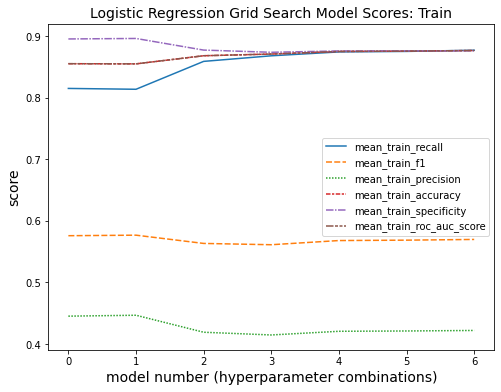

In [140]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_train)
plt.legend(loc=5) #bbox_to_anchor=(1.05,1), 
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Train', fontsize = 14)
# plt.savefig('../output/lr_gridsearch_scores_l1_train_dropDurationMedianIP_cv10.png', bbox_inches='tight')
# plt.savefig('../output/lr_gridsearch_scores_l1l2_train_dropDurationMedianIP_cv10.png', bbox_inches='tight')

### best LR model

[[2930, 503], [37, 316]]

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix: Train')

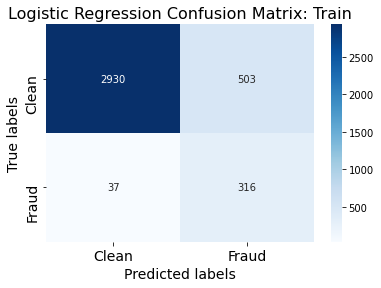

In [31]:
# Zack's best model cm numbers: just to plot
# LR confusion matrix: Train
# use numbers from Zack's model
cm = [[2930, 503], [37, 316]] # train
display(cm)

# print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Train', fontsize=16)

# plt.savefig('../output/lr_cm_train_heatmap_dropDurationMedianIP_zack.png')

[[1285, 186], [16, 136]]

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix: Test')

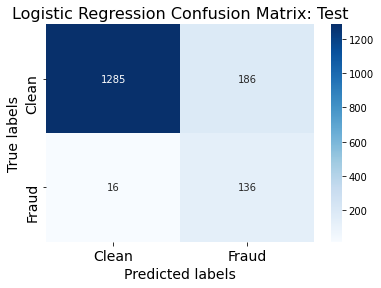

In [32]:
# Zack's best model cm numbers: just to plot
# LR confusion matrix: Test
# use numbers from Zack's model
cm = [[1285, 186], [16, 136]] # test
display(cm)

# print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Test', fontsize=16)

# plt.savefig('../output/lr_cm_test_heatmap_dropDurationMedianIP_zack.png')

In [141]:
best_row = lr_grid_scores.mean_validation_recall.idxmax()
worst_row = lr_grid_scores.mean_validation_recall.idxmin()
print('best lr row number', best_row)
print('worst lr row number', worst_row)
# print('best lr', lr_grid_scores.params[best_row], 'mean_test_recall', round(lr_grid_scores.mean_test_recall[best_row], 4))
print('best lr', lr_grid_scores.params[best_row])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_validation')]].iloc[[best_row,]])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

best lr row number 6
worst lr row number 0
best lr {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
6,0.861951,0.557124,0.411859,0.867376,0.872801,0.867376


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
6,0.876822,0.569716,0.421984,0.87637,0.875917,0.87637


In [113]:
# Zack's grid search best LR model
lr_best_zack = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
lr_best_zack.fit(xtrain, ytrain)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [142]:
# Lu's grid search best LR model
# lr_best_lu = LogisticRegression(penalty='l1', C=0.1, solver='liblinear') # cv=5
lr_best_lu = LogisticRegression(penalty='l1', C=100, solver='liblinear') # cv=10
lr_best_lu.fit(xtrain, ytrain)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

array([[3867,   56],
       [ 202,  203]])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3923
           1       0.78      0.50      0.61       405

    accuracy                           0.94      4328
   macro avg       0.87      0.74      0.79      4328
weighted avg       0.93      0.94      0.93      4328



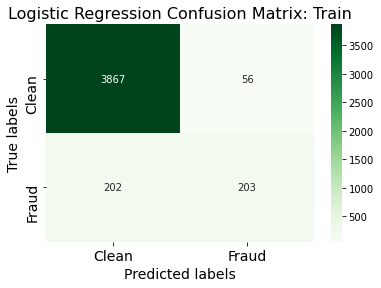

In [146]:
# Zack best LR CM based on Lu's data: Train
# ypred_train = lr_best_zack.predict(xtrain)
ypred_train = lr_best_lu.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred_train, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm)

print(classification_report(ytrain.array, ypred_train))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Train', fontsize=16)

# plt.savefig('../output/lr_best_zack_cm_train_dropDurationMedianIP.png')
plt.savefig('../output/lr_best_lu_cm_train_dropDurationMedianIP_cv10.png')

array([[966,  15],
       [ 57,  44]])

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       981
           1       0.75      0.44      0.55       101

    accuracy                           0.93      1082
   macro avg       0.85      0.71      0.76      1082
weighted avg       0.93      0.93      0.93      1082



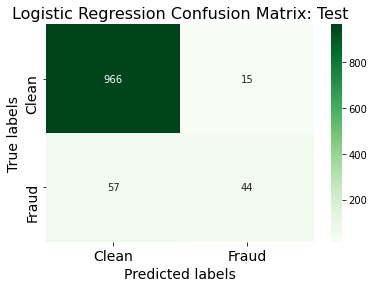

In [145]:
# Zack best LR CM based on Lu's data: Test
# ypred_test = lr_best_zack.predict(xtest)
ypred_test = lr_best_lu.predict(xtest)

labels = np.unique(ytest)
cm = confusion_matrix(ytest, ypred_test, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm)

print(classification_report(ytest.array, ypred_test))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Test', fontsize=16)

# plt.savefig('../output/lr_best_zack_cm_test_dropDurationMedianIP.png')
# plt.savefig('../output/lr_best_lu_cm_test_dropDurationMedianIP.png')
plt.savefig('../output/lr_best_lu_cm_test_dropDurationMedianIP_cv10.png')

### visualzaiton of linearity

#### probability

In [37]:
# best to use PC1, for now try the most important feature TotalRev instead
ypred_prob_train = pd.DataFrame(lr_best_lu.predict_proba(xtrain), index=xtrain.index).rename(columns={0:'no', 1:'yes'})
ypred_prob_train['odds_yes'] = np.exp(ypred_prob_train.yes)
ypred_prob_train['odds_no'] = np.exp(ypred_prob_train.no)
display(ypred_prob_train.head())

,no,yes,odds_yes,odds_no
Provider,,,,
PRV54239,0.985907,0.014093,1.014193,2.680242
PRV53376,0.979162,0.020838,1.021057,2.662223
PRV55143,0.970376,0.029624,1.030067,2.638936
PRV57346,0.984665,0.015335,1.015453,2.676915
PRV53156,0.988938,0.011062,1.011123,2.688379


,no,yes,odds_yes,odds_no,TotalRev
Provider,,,,,
PRV54239,0.985907,0.014093,1.014193,2.680242,21160
PRV53376,0.979162,0.020838,1.021057,2.662223,28500
PRV55143,0.970376,0.029624,1.030067,2.638936,11068
PRV57346,0.984665,0.015335,1.015453,2.676915,152120
PRV53156,0.988938,0.011062,1.011123,2.688379,6610


(array([0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ]),
 <a list of 10 Text major ticklabel objects>)

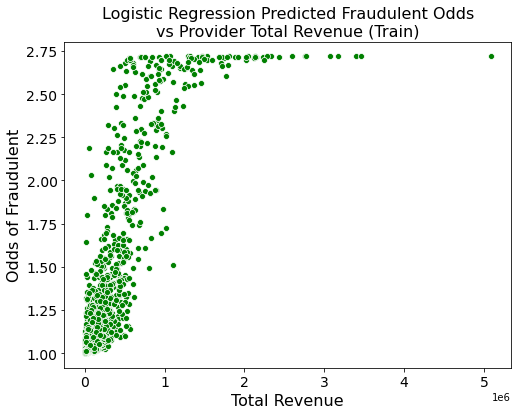

In [38]:
df_prob_train_totalrev = ypred_prob_train.merge(df_dum_drop[['TotalRev']], left_index=True, right_index=True)
display(df_prob_train_totalrev.head())

plt.figure(figsize=(8,6))
k = sns.scatterplot(x = 'TotalRev', y = 'odds_yes', data = df_prob_train_totalrev, color = 'green')
# k.set(xscale = 'log')
plt.title('Logistic Regression Predicted Fraudulent Odds\nvs Provider Total Revenue (Train)', fontsize = 16)
plt.xlabel('Total Revenue', fontsize = 16)
plt.ylabel('Odds of Fraudulent', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.xlim(0,1.5e6)

# plt.savefig('../output/lr_odds_vs_totalrev.png')

#### prediction

In [39]:
# Feature Importance
lr_model = lr_best_zack
recall_coef = pd.DataFrame(lr_model.coef_.flatten(), index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
recall_coef_abs = pd.DataFrame({'abs_coef':abs(lr_model.coef_.flatten()), 'coef': lr_model.coef_.flatten()}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
recall_coef_imp = recall_coef_abs[recall_coef_abs['abs_coef']>0]

print(f"number of predictors before Lasso:", recall_coef_abs.shape[0])
print(f"number of predictors after Lasso:", recall_coef_imp.shape[0])

display(recall_coef_abs.head())

number of predictors before Lasso: 45
number of predictors after Lasso: 12


,abs_coef,coef
DurationMeanIP,0.148930,0.148930
PtAgeMean,0.064088,-0.064088
NumPtsIP,0.057421,-0.057421
NumOfPt,0.007002,-0.007002
ClmNoProc,0.003593,0.003593


,PotentialFraud,DurationMeanIP
Provider,,
PRV51001,0,5.000000
PRV51003,1,5.161290
PRV51004,0,0.000000
PRV51005,1,0.000000
PRV51007,0,5.333333


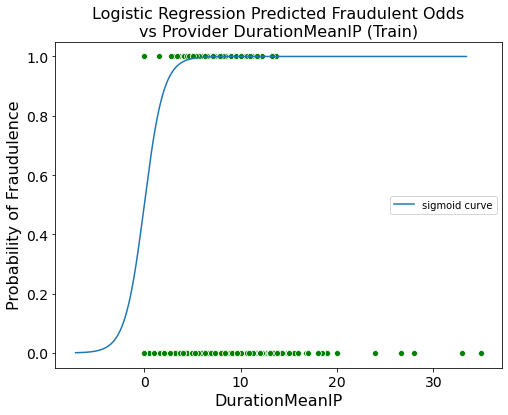

In [40]:
# best to use PC1, for now try the most important feature TotalRev instead
feature = 'DurationMeanIP'

true_vs_feature = pd.DataFrame(y).merge(df_dum_drop[[feature]], left_index=True, right_index=True)
display(true_vs_feature.head())

plt.figure(figsize=(8,6))
k = sns.scatterplot(x = feature, y = 'PotentialFraud', data = true_vs_feature, color = 'green')
# k.set(xscale = 'log')
plt.title(f'Logistic Regression Predicted Fraudulent Odds\nvs Provider {feature} (Train)', fontsize = 16)
plt.xlabel(feature, fontsize = 16)
plt.ylabel('Probability of Fraudulence', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

values = lr_model.intercept_ + np.sum(lr_model.coef_*xtrain, axis = 1)
probas = lr_model.predict_proba(xtrain)[:,1]
values, probas = zip(*sorted(zip(values, probas)))
plt.plot(values, probas, label='sigmoid curve')
plt.legend(loc=5)

# plt.savefig('../output/lr_true_vs_feature_TotalRev.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_TotalRev.png')

# plt.savefig('../output/lr_true_vs_feature_DurationMeanIP.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_DurationMeanIP.png')

# plt.savefig('../output/lr_true_vs_feature_NumOfPt.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_NumOfPt.png')

In [42]:
pd_values = pd.DataFrame(values, index = xtrain.index).rename(columns={0:'values'})
pd_probas = pd.DataFrame(probas, index = xtrain.index).rename(columns={0:'probas'})
lr_vp = pd_values.merge(pd_probas, left_index=True, right_index=True)
lr_vp_feature = lr_vp.merge(df_dum_drop[[feature]], left_index=True, right_index=True)
lr_curve = lr_vp_feature.merge(pd.DataFrame(y), left_index=True, right_index=True)
lr_curve.head()

# lr_curve.to_csv('../output/lr_curve.csv', index=False)

In [350]:
sec1 = lr_curve[lr_curve.DurationMeanIP.between(0,2.99)]
sec2 = lr_curve[lr_curve.DurationMeanIP.between(3,5.99)]
sec3 = lr_curve[lr_curve.DurationMeanIP.between(6,8.99)]
sec4 = lr_curve[lr_curve.DurationMeanIP.between(9,11.99)]
sec5 = lr_curve[lr_curve.DurationMeanIP.between(12,14.99)]

In [361]:
Sec1 = pd.DataFrame(sec1.PotentialFraud.value_counts()).rename(columns={'PotentialFraud':'ProviderNum'})
Sec2 = pd.DataFrame(sec2.PotentialFraud.value_counts()).rename(columns={'PotentialFraud':'ProviderNum'})
Sec3 = pd.DataFrame(sec3.PotentialFraud.value_counts()).rename(columns={'PotentialFraud':'ProviderNum'})
Sec4 = pd.DataFrame(sec4.PotentialFraud.value_counts()).rename(columns={'PotentialFraud':'ProviderNum'})
Sec5 = pd.DataFrame(sec5.PotentialFraud.value_counts()).rename(columns={'PotentialFraud':'ProviderNum'})

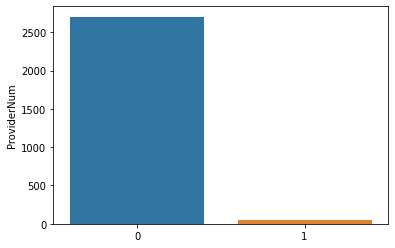

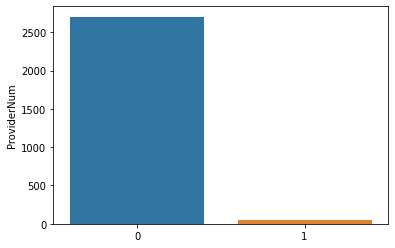

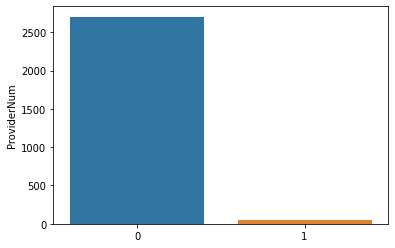

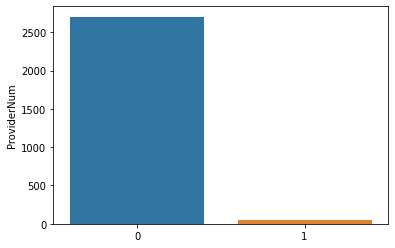

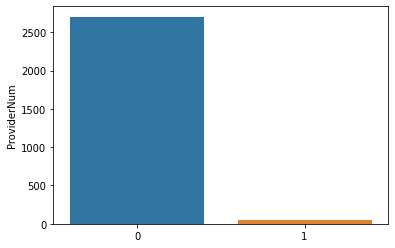

In [363]:
sns.barplot(x = Sec1.index, y = Sec1['ProviderNum'], data = Sec1)
plt.show()
sns.barplot(x = Sec2.index, y = Sec1['ProviderNum'], data = Sec2)
plt.show()
sns.barplot(x = Sec3.index, y = Sec1['ProviderNum'], data = Sec3)
plt.show()
sns.barplot(x = Sec4.index, y = Sec1['ProviderNum'], data = Sec4)
plt.show()
sns.barplot(x = Sec5.index, y = Sec1['ProviderNum'], data = Sec5)
plt.show()

## Random Forest

### train test split for random forest

In [152]:
# remove Duration MedianIP
df_dum_drop = df_dum.drop(['DurationMedianIP'], axis=1)

In [153]:
x = df_dum_drop.drop(['PotentialFraud'], axis = 1)
y = df_dum_drop.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

In [154]:
# remove Duration MedianIP
display(xtrain.shape)
'DurationMedianIP' in xtrain.columns

(4328, 45)

False

In [155]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 45)
(4328, 45)
(1082, 45)


### coarse grid search of RF

In [156]:
rf = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced')

In [157]:
print('num of observations', xtrain.shape[0])
print('num of features', xtrain.shape[1])

max_features_1 = np.arange(2,int(xtrain.shape[1]/2),4)
print('max_features', max_features_1)
min_split_1 = np.arange(5,21,5)
print('min_samples_split', min_split_1) # use one, min_leaf & min_split are smiliar

num of observations 4328
num of features 45
max_features [ 2  6 10 14 18]
min_samples_split [ 5 10 15 20]


In [158]:
rf_params = [{'max_features': max_features_1,'n_estimators': [200, 500],
             'min_samples_split': min_split_1}]

# kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4) # 5 fold cv
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4) # 10 fold cv

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), # use binary not weighted
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # not use balanced_accurarcy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf, verbose=2, scoring=scores, refit=False) # used kf5

%time rf_grid.fit(xtrain, ytrain)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.4s
[CV] max_features=2, min_samples_split=5, n_estim

[CV]  max_features=2, min_samples_split=15, n_estimators=500, total=   2.6s
[CV] max_features=2, min_samples_split=15, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=15, n_estimators=500, total=   2.7s
[CV] max_features=2, min_samples_split=15, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=15, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=20, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=20, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=20, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=20, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=20,

[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.8s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.4s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.3s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.4s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.2s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   5.0s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.2s
[CV] max_features=6, min_samples_split=15,

[CV]  max_features=10, min_samples_split=5, n_estimators=200, total=   2.4s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   6.5s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   6.6s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   5.7s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   6.1s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   6.4s
[CV] max_features=10, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=10, min_samples_split=5, n_estimators=500, total=   6.1s
[CV] max_features=10, min_samples_split=5,

[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   2.2s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   2.1s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   2.1s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   2.0s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.9s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   5.0s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   5.0s
[CV] max_features=10, min_samples_s

[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.6s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.5s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.7s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.6s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.6s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.5s
[CV] max_features=14, min_samples_split=15, n_estimators=200 .........
[CV]  max_features=14, min_samples_split=15, n_estimators=200, total=   2.5s
[CV] max_features=14, min_samples_s

[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=   8.4s
[CV] max_features=18, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=   7.9s
[CV] max_features=18, min_samples_split=5, n_estimators=500 ..........
[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=   7.7s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.1s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.0s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.0s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.4s
[CV] max_features=18, min_samples_spli

[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   8.3s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   8.3s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   7.7s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   8.2s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   8.4s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=   8.3s
[CV] max_features=18, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=20, n_estimators=500, total=  10.9s
CPU times: user 25min 44s, sys: 20.

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 27.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [159]:
keys = list(rf_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [160]:
rf_grid_scores = pd.DataFrame({'params': rf_grid.cv_results_['params'], 
              'mean_validation_recall': rf_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid.cv_results_['mean_train_recall'],
              'mean_validation_f1': rf_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid.cv_results_['mean_train_f1'],
              'mean_validation_precision': rf_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': rf_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': rf_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid.cv_results_['mean_train_specificity'], 
              'mean_validation_roc_auc_score': rf_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid.cv_results_['mean_train_roc_auc_score']
             })
# rf_grid_scores.to_csv('../output/rf_grid_coarse_scores_dropDurationMedianIP.csv')
rf_grid_scores.to_csv('../output/rf_grid_coarse_scores_dropDurationMedianIP_cv10.csv')
rf_grid_scores

,params,mean_validation_recall,mean_train_recall,mean_validation_f1,mean_train_f1,mean_validation_precision,mean_train_precision,mean_validation_accuracy,mean_train_accuracy,mean_validation_specificity,mean_train_specificity,mean_validation_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.535854,0.999452,0.601563,0.985800,0.688256,0.972527,0.933686,0.997304,0.974761,0.997083,0.755307,0.998267
1,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.540732,1.000000,0.605479,0.986474,0.690728,0.973323,0.934148,0.997433,0.974760,0.997168,0.757746,0.998584
2,"{'max_features': 2, 'min_samples_split': 10, '...",0.649512,0.984908,0.626475,0.904867,0.606099,0.836911,0.927679,0.980617,0.956410,0.980174,0.802961,0.982541
3,"{'max_features': 2, 'min_samples_split': 10, '...",0.649390,0.986556,0.626324,0.906730,0.606368,0.838893,0.927679,0.981002,0.956413,0.980429,0.802901,0.983492
4,"{'max_features': 2, 'min_samples_split': 15, '...",0.701220,0.964883,0.623092,0.832834,0.561251,0.732599,0.920513,0.963750,0.943155,0.963633,0.822187,0.964258
5,"{'max_features': 2, 'min_samples_split': 15, '...",0.708659,0.964879,0.625637,0.833355,0.560974,0.733449,0.920513,0.963879,0.942391,0.963775,0.825525,0.964327
6,"{'max_features': 2, 'min_samples_split': 20, '...",0.740610,0.951714,0.621415,0.784865,0.535950,0.667828,0.915429,0.951171,0.933471,0.951114,0.837040,0.951414
7,"{'max_features': 2, 'min_samples_split': 20, '...",0.748110,0.953083,0.626127,0.784024,0.539083,0.665922,0.916354,0.950863,0.933726,0.950633,0.840918,0.951858
8,"{'max_features': 6, 'min_samples_split': 5, 'n...",0.525854,1.000000,0.600527,0.996039,0.707871,0.992111,0.934841,0.999256,0.977055,0.999179,0.751454,0.999589
9,"{'max_features': 6, 'min_samples_split': 5, 'n...",0.528293,1.000000,0.605460,0.996856,0.714636,0.993733,0.935766,0.999410,0.977820,0.999349,0.753057,0.999674


In [161]:
best_row = rf_grid_scores.mean_validation_recall.idxmax()
worst_row = rf_grid_scores.mean_validation_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF coarse', rf_grid_scores.params[best_row])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_validation')]].iloc[[best_row,]])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

rf_coarse_mf = rf_grid_scores.params[best_row]['max_features']
rf_coarse_mss = rf_grid_scores.params[best_row]['min_samples_split']
rf_coarse_ne = rf_grid_scores.params[best_row]['n_estimators']
print(rf_coarse_mf, rf_coarse_mss, rf_coarse_ne)

best RF row number 7
worst RF row number 17
best RF coarse {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 500}


,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
7,0.74811,0.626127,0.539083,0.916354,0.933726,0.840918


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
7,0.953083,0.784024,0.665922,0.950863,0.950633,0.951858


2 20 500


In [162]:
# best RF model fit: coarse grid search
rf_best_coarse = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                        max_features=rf_coarse_mf, 
                                        min_samples_split=rf_coarse_mss, 
                                        n_estimators=rf_coarse_ne)
rf_best_coarse.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

,0,1
0,3732,191
1,22,383


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3923
           1       0.67      0.95      0.78       405

    accuracy                           0.95      4328
   macro avg       0.83      0.95      0.88      4328
weighted avg       0.96      0.95      0.95      4328



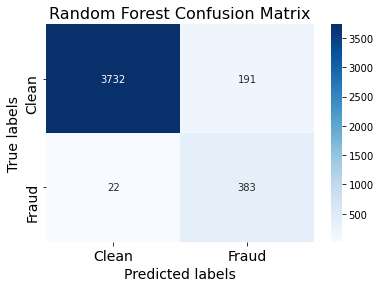

In [163]:
# confusion matrix
ypred = rf_best_coarse.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
# plt.savefig('../output/rf_grid_coarse_cm_heatmap_dropDurationMedianIP.png')
plt.savefig('../output/rf_grid_coarse_cm_heatmap_dropDurationMedianIP_cv10.png')

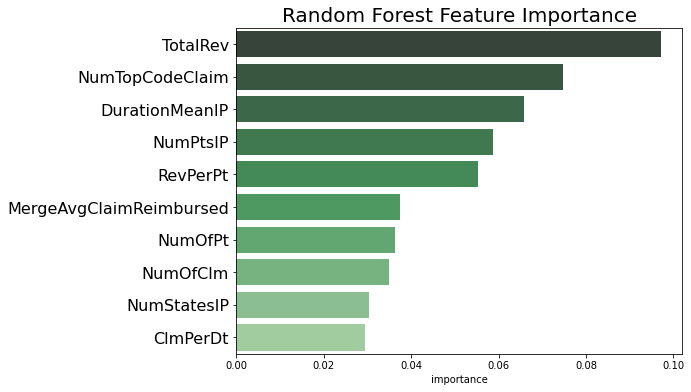

In [164]:
rf_feature_imp = pd.DataFrame(data = rf_best_coarse.feature_importances_, index=xtrain.columns, 
                              columns=['importance']).sort_values(by = 'importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp.index[:10], x = 'importance', data = rf_feature_imp[:10],palette=sns.color_palette('Greens_d', n_colors=10)) #Greens_d
plt.title('Random Forest Feature Importance', fontsize=20)
plt.yticks(fontsize = 16)

# plt.savefig('../output/rf_grid_coarse_feature_importance_green_dropDurationMedianIP.png', bbox_inches='tight')
# rf_feature_imp.to_csv('../output/rf_grid_coarse_feature_importance.csv')

plt.savefig('../output/rf_grid_coarse_feature_importance_green_dropDurationMedianIP_cv10.png', bbox_inches='tight')
rf_feature_imp.to_csv('../output/rf_grid_coarse_feature_importance_cv10.csv')

In [165]:
rf_grid_scores_test = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('validation')]]
display(rf_grid_scores_test)
rf_grid_scores_train = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('train')]]
display(rf_grid_scores_train)

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.535854,0.601563,0.688256,0.933686,0.974761,0.755307
1,0.540732,0.605479,0.690728,0.934148,0.974760,0.757746
2,0.649512,0.626475,0.606099,0.927679,0.956410,0.802961
3,0.649390,0.626324,0.606368,0.927679,0.956413,0.802901
4,0.701220,0.623092,0.561251,0.920513,0.943155,0.822187
5,0.708659,0.625637,0.560974,0.920513,0.942391,0.825525
6,0.740610,0.621415,0.535950,0.915429,0.933471,0.837040
7,0.748110,0.626127,0.539083,0.916354,0.933726,0.840918
8,0.525854,0.600527,0.707871,0.934841,0.977055,0.751454
9,0.528293,0.605460,0.714636,0.935766,0.977820,0.753057


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.999452,0.985800,0.972527,0.997304,0.997083,0.998267
1,1.000000,0.986474,0.973323,0.997433,0.997168,0.998584
2,0.984908,0.904867,0.836911,0.980617,0.980174,0.982541
3,0.986556,0.906730,0.838893,0.981002,0.980429,0.983492
4,0.964883,0.832834,0.732599,0.963750,0.963633,0.964258
5,0.964879,0.833355,0.733449,0.963879,0.963775,0.964327
6,0.951714,0.784865,0.667828,0.951171,0.951114,0.951414
7,0.953083,0.784024,0.665922,0.950863,0.950633,0.951858
8,1.000000,0.996039,0.992111,0.999256,0.999179,0.999589
9,1.000000,0.996856,0.993733,0.999410,0.999349,0.999674


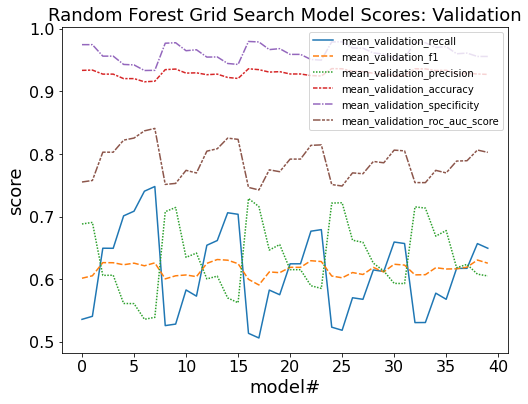

In [166]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_test)
plt.legend( loc=1) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('../output/rf_grid_coarse_scores_validation_dropDurationMedianIP.png', bbox_inches='tight')
plt.savefig('../output/rf_grid_coarse_scores_validation_dropDurationMedianIP_cv10.png', bbox_inches='tight')

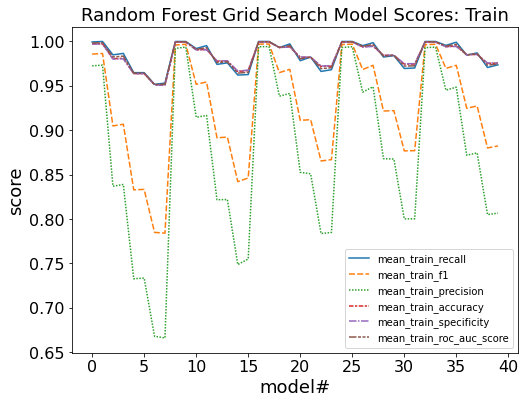

In [167]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('../output/rf_grid_coarse_scores_train_dropDurationMedianIP.png', bbox_inches='tight')
plt.savefig('../output/rf_grid_coarse_scores_train_dropDurationMedianIP_cv10.png', bbox_inches='tight')

### fine gridsearch of random forest

In [168]:
xtrain.shape

(4328, 45)

In [170]:
print('best RF coarse', rf_grid_scores.params[best_row])
max_features_2 = np.arange(1,5,1)
print('max_features', max_features_2)
min_split_2 = np.arange(16, 25, 1)
print('min_split', min_split_2)
# estimators = [200,500, 1000] # cv5
estimators = [500, 1000] # cv10
print('n_estimator', estimators)

best RF coarse {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 500}
max_features [1 2 3 4]
min_split [16 17 18 19 20 21 22 23 24]
n_estimator [500, 1000]


In [171]:
rf_params = [{'max_features': max_features_2,'n_estimators': estimators,
             'min_samples_split': min_split_2}] 

# kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4) # 5 fold cv
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4) # 10 fold cv

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), 
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid_fine = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf, verbose=2, scoring=scores, refit=False)

%time rf_grid_fine.fit(xtrain, ytrain)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.7s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.7s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.7s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.3s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=16,

[CV]  max_features=1, min_samples_split=18, n_estimators=1000, total=   3.9s
[CV] max_features=1, min_samples_split=18, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=18, n_estimators=1000, total=   4.0s
[CV] max_features=1, min_samples_split=18, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=18, n_estimators=1000, total=   3.8s
[CV] max_features=1, min_samples_split=19, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=19, n_estimators=500, total=   2.0s
[CV] max_features=1, min_samples_split=19, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=19, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=19, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=19, n_estimators=500, total=   1.9s
[CV] max_features=1, min_samples_split=19, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=19, n_estimators=500, total=   1.9s
[CV] max_features=1, min_samples_split=

[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   4.0s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   3.8s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   3.8s
[CV] max_features=1, min_samples_split=21, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=21, n_estimators=1000, total=   3.9s
[CV] max_features=1, min_samples_sp

[CV]  max_features=1, min_samples_split=24, n_estimators=500, total=   2.0s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   3.8s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   4.0s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   3.8s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=24, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=24, n_estimators=1000, total=   4.8s
[CV] max_features=1, min_samples_spl

[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=18, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=18, n_estimators=1000, total=   4.6s
[CV] max_features=2, min_samples_split=18, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=18, n_estimators=1000, total=   4.5s
[CV] max_features=2, min_samples_split=1

[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.1s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.2s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.2s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.2s
[CV] max_features=2, min_samples_split=21, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=21, n_estimators=500, total=   2.2s
[CV] max_features=2, min_samples_split=21,

[CV]  max_features=2, min_samples_split=23, n_estimators=1000, total=   8.1s
[CV] max_features=2, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=23, n_estimators=1000, total=   6.6s
[CV] max_features=2, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=23, n_estimators=1000, total=   6.6s
[CV] max_features=2, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=24, n_estimators=500, total=   4.1s
[CV] max_features=2, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=24, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=24, n_estimators=500, total=   4.9s
[CV] max_features=2, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=24, n_estimators=500, total=   3.7s
[CV] max_features=2, min_samples_split=

[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.6s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.2s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   4.9s
[CV] max_features=3, min_samples_split=17, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=17, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_sp

[CV]  max_features=3, min_samples_split=20, n_estimators=500, total=   2.6s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   4.9s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   4.7s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   4.8s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.1s
[CV] max_features=3, min_samples_spl

[CV]  max_features=3, min_samples_split=23, n_estimators=500, total=   2.6s
[CV] max_features=3, min_samples_split=23, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=23, n_estimators=500, total=   2.4s
[CV] max_features=3, min_samples_split=23, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=23, n_estimators=500, total=   2.4s
[CV] max_features=3, min_samples_split=23, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=23, n_estimators=500, total=   2.5s
[CV] max_features=3, min_samples_split=23, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=23, n_estimators=500, total=   2.4s
[CV] max_features=3, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=23, n_estimators=1000, total=   4.8s
[CV] max_features=3, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=23, n_estimators=1000, total=   4.9s
[CV] max_features=3, min_samples_split=2

[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.6s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.9s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=17, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=17, n_estimators=500, total=   2.9s
[CV] max_features=4, min_samples_split=17,

[CV]  max_features=4, min_samples_split=19, n_estimators=1000, total=   5.6s
[CV] max_features=4, min_samples_split=19, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=19, n_estimators=1000, total=   5.4s
[CV] max_features=4, min_samples_split=19, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=19, n_estimators=1000, total=   5.4s
[CV] max_features=4, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=20, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=20, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=20, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=20, n_estimators=500, total=   2.9s
[CV] max_features=4, min_samples_split=

[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.7s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.4s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.6s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.5s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.9s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.7s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.3s
[CV] max_features=4, min_samples_sp

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 49.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [172]:
rf_grid_fine_scores = pd.DataFrame({'params': rf_grid_fine.cv_results_['params'], 
              'mean_validation_recall': rf_grid_fine.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid_fine.cv_results_['mean_train_recall'],
              'mean_validation_f1': rf_grid_fine.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid_fine.cv_results_['mean_train_f1'],
              'mean_validation_precision': rf_grid_fine.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid_fine.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': rf_grid_fine.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid_fine.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': rf_grid_fine.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid_fine.cv_results_['mean_train_specificity'], 
              'mean_validation_roc_auc_score': rf_grid_fine.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid_fine.cv_results_['mean_train_roc_auc_score']
             })
# rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores_dropDurationMedianIP.csv')
rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores_dropDurationMedianIP_cv10.csv')
rf_grid_fine_scores

,params,mean_validation_recall,mean_train_recall,mean_validation_f1,mean_train_f1,mean_validation_precision,mean_train_precision,mean_validation_accuracy,mean_train_accuracy,mean_validation_specificity,mean_train_specificity,mean_validation_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 1, 'min_samples_split': 16, '...",0.725915,0.959118,0.627207,0.803680,0.552667,0.691618,0.919127,0.956151,0.939079,0.955844,0.832497,0.957481
1,"{'max_features': 1, 'min_samples_split': 16, '...",0.723415,0.959669,0.621159,0.804155,0.544801,0.692037,0.917278,0.956254,0.937294,0.955901,0.830354,0.957785
2,"{'max_features': 1, 'min_samples_split': 17, '...",0.730854,0.956926,0.621060,0.792920,0.540610,0.676928,0.916356,0.953224,0.935510,0.952842,0.833182,0.954884
3,"{'max_features': 1, 'min_samples_split': 17, '...",0.735732,0.956101,0.624454,0.793958,0.542998,0.678862,0.917048,0.953558,0.935765,0.953295,0.835748,0.954698
4,"{'max_features': 1, 'min_samples_split': 18, '...",0.740732,0.954456,0.622639,0.783569,0.537666,0.664605,0.915893,0.950657,0.933979,0.950265,0.837355,0.952360
5,"{'max_features': 1, 'min_samples_split': 18, '...",0.745610,0.953634,0.628174,0.784042,0.543266,0.665678,0.917279,0.950837,0.935000,0.950548,0.840305,0.952091
6,"{'max_features': 1, 'min_samples_split': 19, '...",0.750488,0.951711,0.627128,0.774761,0.539168,0.653314,0.916354,0.948218,0.933470,0.947857,0.841979,0.949784
7,"{'max_features': 1, 'min_samples_split': 19, '...",0.748049,0.951712,0.625748,0.774600,0.538508,0.653084,0.916124,0.948167,0.933471,0.947801,0.840760,0.949757
8,"{'max_features': 1, 'min_samples_split': 20, '...",0.750488,0.950889,0.622035,0.767851,0.531942,0.643934,0.914507,0.946190,0.931432,0.945705,0.840960,0.948297
9,"{'max_features': 1, 'min_samples_split': 20, '...",0.750488,0.949518,0.621971,0.766991,0.531782,0.643336,0.914506,0.946010,0.931432,0.945648,0.840960,0.947583


In [173]:
rf_grid_fine_scores_validation = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('validation')]]
display(rf_grid_fine_scores_validation)
rf_grid_fine_scores_train = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('train')]]
display(rf_grid_fine_scores_train)

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.725915,0.627207,0.552667,0.919127,0.939079,0.832497
1,0.723415,0.621159,0.544801,0.917278,0.937294,0.830354
2,0.730854,0.621060,0.540610,0.916356,0.935510,0.833182
3,0.735732,0.624454,0.542998,0.917048,0.935765,0.835748
4,0.740732,0.622639,0.537666,0.915893,0.933979,0.837355
5,0.745610,0.628174,0.543266,0.917279,0.935000,0.840305
6,0.750488,0.627128,0.539168,0.916354,0.933470,0.841979
7,0.748049,0.625748,0.538508,0.916124,0.933471,0.840760
8,0.750488,0.622035,0.531942,0.914507,0.931432,0.840960
9,0.750488,0.621971,0.531782,0.914506,0.931432,0.840960


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.959118,0.803680,0.691618,0.956151,0.955844,0.957481
1,0.959669,0.804155,0.692037,0.956254,0.955901,0.957785
2,0.956926,0.792920,0.676928,0.953224,0.952842,0.954884
3,0.956101,0.793958,0.678862,0.953558,0.953295,0.954698
4,0.954456,0.783569,0.664605,0.950657,0.950265,0.952360
5,0.953634,0.784042,0.665678,0.950837,0.950548,0.952091
6,0.951711,0.774761,0.653314,0.948218,0.947857,0.949784
7,0.951712,0.774600,0.653084,0.948167,0.947801,0.949757
8,0.950889,0.767851,0.643934,0.946190,0.945705,0.948297
9,0.949518,0.766991,0.643336,0.946010,0.945648,0.947583


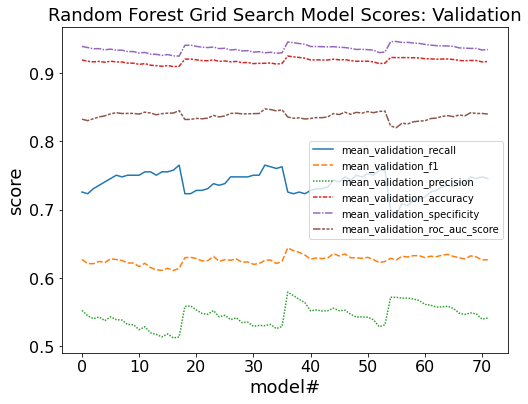

In [174]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_fine_scores_validation)
# sns.lineplot(data =rf_grid_fine_scores[['mean_validation_recall','mean_validation_precision']])
plt.legend( loc=5) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('../output/rf_grid_fine_scores_validation_2score_dropDurationMedianIP.png', bbox_inches='tight')
plt.savefig('../output/rf_grid_fine_scores_validation_allscore_dropDurationMedianIP_cv10.png', bbox_inches='tight')

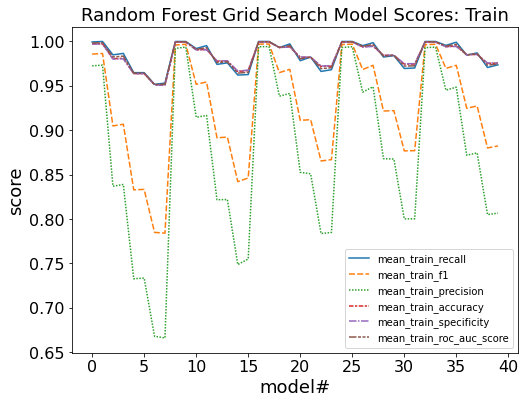

In [175]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
# sns.lineplot(data =rf_grid_fine_scores[['mean_train_recall','mean_train_precision']])
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.savefig('../output/rf_grid_fine_scores_train_2score_dropDurationMedianIP.png', bbox_inches='tight')
plt.savefig('../output/rf_grid_fine_scores_train_allscore_dropDurationMedianIP_cv10.png', bbox_inches='tight')

In [176]:
# choose best model based on a score: favor sensitivity
# want to maximize false positive over all positives (low precision), minimize false negative (high recall)
best_row = rf_grid_fine_scores.mean_validation_recall.idxmax()
worst_row = rf_grid_fine_scores.mean_validation_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF fine', rf_grid_fine_scores.params[best_row])
display(rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('mean_validation')]].iloc[[best_row,]])
display(rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

rf_fine_mf = rf_grid_fine_scores.params[best_row]['max_features']
rf_fine_mss = rf_grid_fine_scores.params[best_row]['min_samples_split']
rf_fine_ne = rf_grid_fine_scores.params[best_row]['n_estimators']
print(rf_fine_mf, rf_fine_mss, rf_fine_ne)

best RF row number 17
worst RF row number 55
best RF fine {'max_features': 1, 'min_samples_split': 24, 'n_estimators': 1000}


,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
17,0.765305,0.61442,0.513884,0.909886,0.924805,0.845055


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
17,0.939092,0.737093,0.60663,0.937307,0.937123,0.938107


1 24 1000


In [177]:
# best RF model fit: fine grid search
rf_best_fine = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                        max_features=rf_fine_mf, 
                                        min_samples_split=rf_fine_mss, 
                                        n_estimators=rf_fine_ne, )
rf_best_fine.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=24,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [178]:
rf_best_fine.score(xtrain,ytrain)

0.9383086876155268

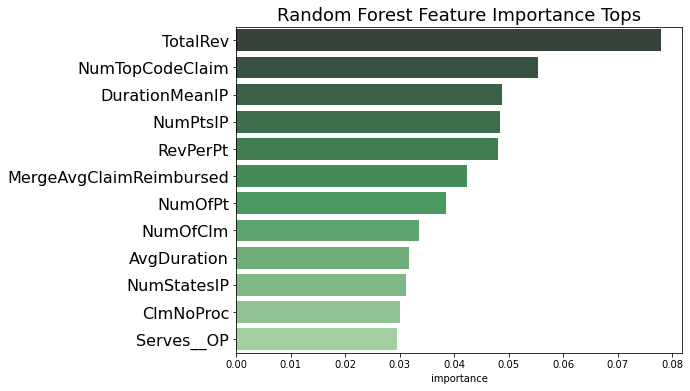

In [179]:
rf_feature_imp_fine = pd.DataFrame(data = rf_best_fine.feature_importances_, index=xtrain.columns, 
                                   columns=['importance']).sort_values(by = 'importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp_fine.index[:12], x = 'importance', 
            data = rf_feature_imp_fine[:12],palette=sns.color_palette('Greens_d', n_colors=12))
plt.title('Random Forest Feature Importance Tops', fontsize=18)
plt.yticks(fontsize = 16)

# rf_feature_imp_fine.to_csv('../output/rf_grid_fine_features_importance_dropDurationMedianIP.csv')
# plt.savefig('../output/rf_fine_feature_importance_green_dropDurationMedianIP.png', bbox_inches='tight')

rf_feature_imp_fine.to_csv('../output/rf_grid_fine_features_importance_dropDurationMedianIP_cv10.csv')
plt.savefig('../output/rf_fine_feature_importance_green_dropDurationMedianIP_cv10.png', bbox_inches='tight')

,0,1
0,3682,241
1,26,379


              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3923
           1       0.61      0.94      0.74       405

    accuracy                           0.94      4328
   macro avg       0.80      0.94      0.85      4328
weighted avg       0.96      0.94      0.94      4328



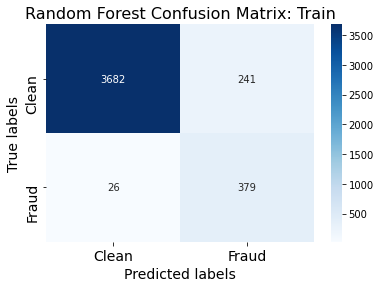

In [180]:
# confusion matrix
ypred = rf_best_fine.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix: Train', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)

# plt.savefig('../output/rf_fine_train_cm_heatmap_dropDurationMedianIP.png')
plt.savefig('../output/rf_fine_train_cm_heatmap_dropDurationMedianIP_cv10.png')

,0,1
0,906,75
1,28,73


              precision    recall  f1-score   support

           0       0.97      0.92      0.95       981
           1       0.49      0.72      0.59       101

    accuracy                           0.90      1082
   macro avg       0.73      0.82      0.77      1082
weighted avg       0.93      0.90      0.91      1082



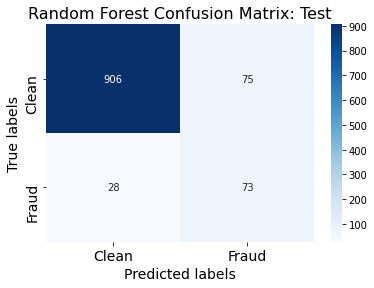

In [181]:
# confusion matrix
ypred_test = rf_best_fine.predict(xtest)

labels = np.unique(ytest)
cm = confusion_matrix(ytest, ypred_test, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytest.array, ypred_test))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix: Test', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)

# plt.savefig('../output/rf_fine_test_cm_heatmap_dropDurationMedianIP.png')
plt.savefig('../output/rf_fine_test_cm_heatmap_dropDurationMedianIP_cv10.png')

### Model Comparison

In [ ]:
# scores
# LR: Validation Train 0.90 Test 0.89
# RF: Validation Train 0.94 Test 0.70
# XGBoost: Validation 0.9372; Train 0.9478; Test 0.9269
# SVM: Validation Train Test

In [17]:
model_scores = {'LR': [0.9, 0.89], 'RF': [0.94, 0.70], 'XGB': [0.95, 0.93], 'SVM':[0.89, 0.88]}
model_scores = pd.DataFrame(model_scores, index=['Train', 'Test']).reset_index()
display(model_scores)

model_scores = pd.melt(model_scores, id_vars = ['index'], value_vars = ['LR', 'RF', 'XGB', 'SVM'])
model_scores = model_scores.rename(columns={'variable':'Model', 'value':'Score', 'index':'Type'})
display(model_scores)

,index,LR,RF,XGB,SVM
0,Train,0.90,0.94,0.95,0.89
1,Test,0.89,0.70,0.93,0.88


,Type,Model,Score
0,Train,LR,0.90
1,Test,LR,0.89
2,Train,RF,0.94
3,Test,RF,0.70
4,Train,XGB,0.95
5,Test,XGB,0.93
6,Train,SVM,0.89
7,Test,SVM,0.88


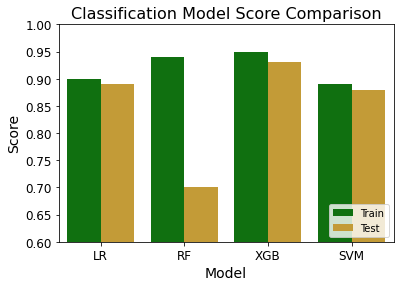

In [31]:
sns.barplot(y = 'Score', x = 'Model', hue = 'Type', data = model_scores, 
            palette={'Test':'goldenrod', 'Train':'green'})
plt.title('Classification Model Score Comparison', fontsize = 16)
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Model', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0.6,1)
plt.legend(loc = 4)

plt.savefig('../output/model_score_compare_4models.png')

In [186]:
# model_scores = [[0.9, 0.89],
#                [0.94, 0.7]]
# model_scores = pd.DataFrame(model_scores, columns=['Train', 'Test'], index=['LogisticRegression', 'RandomForest'])
# display(model_scores)
# sns.barplot(x = model_scores.index, y = 'Train', data = model_scores)

cv10


,Model,Type,Score
0,LogisticRegression,train,0.88
1,LogisticRegression,test,0.86
2,RandomForest,train,0.94
3,RandomForest,test,0.77


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

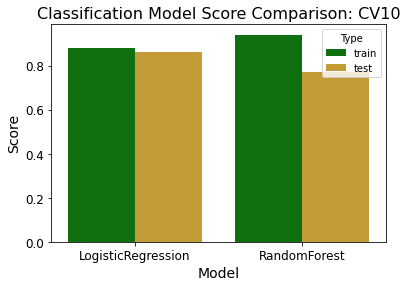

In [193]:
# model_scores = [['LogisticRegression', 'LogisticRegression', 'RandomForest','RandomForest'], 
#                 ['train', 'test', 'train', 'test'], [0.9, 0.89, 0.94, 0.7]] # cv5
#cv10 
# model_scores = [['LogisticRegression', 'LogisticRegression', 'RandomForest','RandomForest'], 
#                 ['train', 'test', 'train', 'test'], [0.88, 0.86, 0.94, 0.77]] # cv10
# model_scores = pd.DataFrame(model_scores).T.rename(columns={0:'Model', 1:'Type', 2:'Score'})
# print('cv10')
# display(model_scores)

sns.barplot(y = 'Score', x = 'Model', hue = 'Type', data = model_scores, 
            palette={'test':'goldenrod', 'train':'green'})
plt.title('Classification Model Score Comparison: CV10', fontsize = 16)
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Model', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.savefig('../output/model_score_compare_cv10.png')

## EDA feature

In [1074]:
df_dum.columns

Index(['PotentialFraud', 'DurationMedianIP', 'DurationMeanIP', 'DurationMedianOP', 'DurationMeanOP', 'ChronCondsMedian', 'ChronCondsMean', 'ChronConsMode', 'PtAgeMedian', 'PtAgeMean', 'NumPtsIP', 'NumPtsOP', 'NumStatesIP', 'NumStatesOP', 'SharePhysician', 'MergeAvgClaimReimbursed', 'NumTopCodeClaim', 'DupClaimNum_IP', 'DupClaimRatio_IP', 'DupClaim_IP', 'DupClaimStatesNum_IP', 'DupClaimMultiState_IP', 'DupClaimProviderNum_IP', 'DupClaimMultiProvider_IP', 'DupClaimStartDtNum_IP', 'DupClaimMultiStartDt_IP', 'DupClaimNum_OP', 'DupClaimRatio_OP', 'DupClaim_OP', 'DupClaimStatesNum_OP', 'DupClaimMultiState_OP', 'DupClaimProviderNum_OP', 'DupClaimMultiProvider_OP', 'DupClaimStartDtNum_OP', 'DupClaimMultiStartDt_OP', 'AvgDuration', 'NumOfPt', 'NumOfClm', 'ClmPerPt', 'TotalRev', 'RevPerPt', 'ClmNoPhy', 'ClmAllPhy', 'ClmNoProc', 'ClmPerDt', 'Serves__IP', 'Serves__OP'], dtype='object')

Text(0.5, 1.0, 'DupClaimFlag')

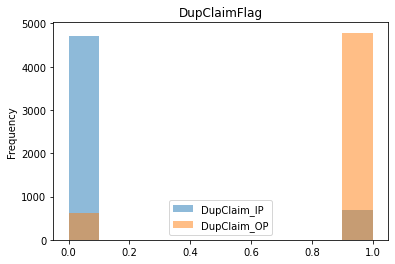

In [128]:
df_dum.DupClaim_IP.plot.hist(alpha = 0.5)
df_dum.DupClaim_OP.plot.hist(alpha = 0.5)
plt.legend()
plt.title('DupClaimFlag')
# plt.savefig('../output/flag_dupclaimratio.png')

In [1115]:
from statsmodels.graphics.mosaicplot import mosaic
# mosaic plot
df_dum[['DupClaim_IP', 'DupClaim_OP']].head()
a = pd.DataFrame(df_dum.DupClaim_IP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
b = pd.DataFrame(df_dum.DupClaim_OP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
display(a)
display(b)
c = a.merge(b, how='inner', on='PotentialFraud')
c['PotentialFraud'] = np.where(c['PotentialFraud'] == 0, 'No', 'Yes')
c.set_index('PotentialFraud', inplace = True)
display(c)
d = c.to_dict()

,PotentialFraud,DupClaim_IP
0,0,4715
1,1,695


,PotentialFraud,DupClaim_OP
0,1,4786
1,0,624


,DupClaim_IP,DupClaim_OP
PotentialFraud,,
No,4715,624
Yes,695,4786


{'DupClaim_IP': {'No': 4715, 'Yes': 695}, 'DupClaim_OP': {'No': 624, 'Yes': 4786}}


(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('4715', '624'),
               (0.0, 0.0, 0.49751243781094534, 0.9966777408637874)),
              (('4715', '4786'), (0.0, 1.0, 0.49751243781094534, 0.0)),
              (('695', '624'),
               (0.5024875621890548, 0.0, 0.49751243781094534, 0.0)),
              (('695', '4786'),
               (0.5024875621890548,
                0.0033222591362126247,
                0.49751243781094534,
                0.9966777408637874))]))

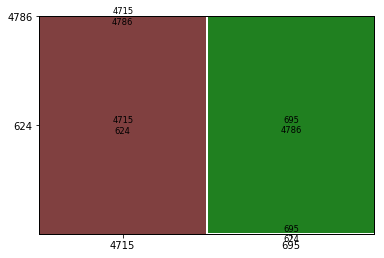

In [1120]:
print(d)
DupClaim_IP = [4715, 695]
DupClaim_OP = [624,4786]
data = pd.DataFrame({'IP': DupClaim_IP, 'OP': DupClaim_OP})
mosaic(data, ['IP', 'OP'])

(<Figure size 432x288 with 1 Axes>,
 OrderedDict([(('No',), (0.0, 0.0, 0.8629051444885709, 1.0)),
              (('Yes',), (0.8728061345875808, 0.0, 0.1271938654124192, 1.0))]))

<Figure size 72x432 with 0 Axes>

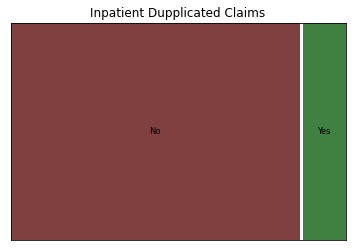

In [1118]:
plt.figure(figsize=(1,6))
mosaic(d['DupClaim_IP'], title = 'Inpatient Dupplicated Claims', gap=0.01, axes_label = False)
# mosaic(d['DupClaim_OP'], title = 'Outpatient Dupplicated Claims', gap=0.01, axes_label = False)

## XGBoost

In [ ]:
# 

### K means clustering